<a href="https://colab.research.google.com/github/rishi15-t/PP-MM/blob/master/PP_MM_pattern_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
dataset = pd.read_pickle('/content/drive/My Drive/dataset/w2v_vgg_embeddings.pkl')

In [0]:
import torch
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


def Train_Test_Val_Split(data , test_data_fraction = 0.3, val_data_fraction = 0.1) :
    
  
    data_genres_one_hot_encoding = pd.DataFrame.from_items(zip(data['genres'].index, data['genres'].values)).T
    Label_names = np.array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'])
    data_genres_one_hot_encoding.columns = Label_names
    Data_train, Data_test, Labels_train, Labels_test = train_test_split(data, data_genres_one_hot_encoding, test_size = test_data_fraction)

    Data_train, Data_val, Labels_train, Labels_val = train_test_split(Data_train, Labels_train, test_size = val_data_fraction)

    Data_train = Data_train.reset_index(drop=True)
    Data_test = Data_test.reset_index(drop=True)
    Data_val = Data_val.reset_index(drop=True)
    
    Labels_train = torch.tensor(Labels_train.values)
    Labels_test = torch.tensor(Labels_test.values)
    Labels_val = torch.tensor(Labels_val.values)
    
    return (Data_train, Data_test, Data_val, Labels_train, Labels_test, Labels_val, Label_names)
    
Data_train, Data_test, Data_val, Labels_train_tensor, Labels_test_tensor, Labels_val_tensor, Label_names = Train_Test_Val_Split(dataset)

Data_train_tensor_text = torch.tensor(Data_train['w2v_embeddings'])
Data_test_tensor_text = torch.tensor(Data_test['w2v_embeddings'])
Data_val_tensor_text = torch.tensor(Data_val['w2v_embeddings'])

Data_train_tensor_image = torch.tensor(Data_train['vgg16_embeddings'])
Data_test_tensor_image = torch.tensor(Data_test['vgg16_embeddings'])
Data_val_tensor_image = torch.tensor(Data_val['vgg16_embeddings'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  # Remove the CWD from sys.path while we load stuff.


In [0]:
!pip install git+https://github.com/uber/pyro.git

  Cloning https://github.com/uber/pyro.git to /tmp/pip-req-build-h2ssot4p
  Running command git clone -q https://github.com/uber/pyro.git /tmp/pip-req-build-h2ssot4p
     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for pyro-ppl: filename=pyro_ppl-1.2.1+13b08a7c-cp36-none-any.whl size=484817 sha256=6d37f86557422c7a06d69bb7f4f00354610f8f6f1ed79a678b961a7d3659d13e
  Stored in directory: /tmp/pip-ephem-wheel-cache-geuixd3r/wheels/3c/10/ed/73d2332a097e2e9dc7d601ca2a99b0b4f9634e393474b78137
Successfully built pyro-ppl
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import torch
from torch.utils.data import IterableDataset, Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch import autograd, nn, tanh, optim
import torch.nn.functional as F
from torch.nn.functional import softplus
import numpy as np 
from pathlib import Path
import pyro
from pyro import poutine
from pyro.distributions import Normal, Categorical, Laplace
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import time
import datetime


# models

class Classify(nn.Module):
    # Classifier
    def __init__(self, out_dim1, out_dim2):
        super(Classify, self).__init__()
        self.out_dim1 = out_dim1
        self.out_dim2 = out_dim2
        self.c0 = nn.Linear(out_dim1, out_dim1)
        self.c1 = nn.Linear(out_dim1, out_dim2)

    def forward(self, x):
        x = x.view(-1, self.out_dim1)
        x = self.c0(x)
        x = torch.tanh(x)
        x = self.c1(x)
        x = torch.tanh(x)
        return(x)
        
class GMU(nn.Module):
    
    def __init__(self, out_dim, textual_dim = 300, visual_dim = 4096, num_classes = 23, aux_loss_multiplier=None):
        super(GMU, self).__init__()
        self.num_classes = num_classes
        self.out_dim = out_dim

        self.fc0 = nn.Linear(textual_dim, self.out_dim)
        self.fc1 = nn.Linear(visual_dim, self.out_dim)
        self.fc2 = nn.Linear(textual_dim + visual_dim, self.out_dim)
        self.fc3 = nn.Linear(self.out_dim, self.num_classes)
        self.class0 = Classify(self.out_dim, self.out_dim)

    def forward(self, x_text, x_visual):

        t = self.fc0(x_text)
        t = torch.tanh(t)
        v = self.fc1(x_visual)
        v = torch.tanh(v)

        concat = torch.cat((x_text, x_visual), 1)
        attend = self.fc2(concat)
        attend = torch.sigmoid(attend)
        attend = attend * v + (1 - attend) * t
        classify_out = self.class0(attend)
        out = self.fc3(classify_out)
        out = torch.sigmoid(out)

        return out


In [0]:
#Pyro functions


def model(x_text, x_visual, x_label):

        fc0_prior_w = Laplace(loc=torch.ones_like(net.fc0.weight), scale=torch.ones_like(net.fc0.weight))
        fc0_prior_b = Laplace(loc=torch.ones_like(net.fc0.bias), scale=torch.ones_like(net.fc0.bias))
        fc1_prior_w = Laplace(loc=torch.ones_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
        fc1_prior_b = Laplace(loc=torch.ones_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
        fc2_prior_w = Laplace(loc=torch.ones_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight))
        fc2_prior_b = Laplace(loc=torch.ones_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias))
        fc3_prior_w = Laplace(loc=torch.ones_like(net.fc3.weight), scale=torch.ones_like(net.fc3.weight))
        fc3_prior_b = Laplace(loc=torch.ones_like(net.fc3.bias), scale=torch.ones_like(net.fc3.bias))

        priors = {
            'fc0.weight': fc0_prior_w, 'fc0.bias': fc0_prior_b,
            'fc1.weight': fc1_prior_w, 'fc1.bias': fc1_prior_b,
            'fc2.weight': fc2_prior_w, 'fc2.bias': fc2_prior_b,
            'fc3.weight': fc3_prior_w, 'fc3.bias': fc3_prior_b}

        lifted_module = pyro.random_module("gmu", net, priors)
        lifted_reg_model = lifted_module()
        
        with pyro.plate("map"):
            x_text = x_text
            x_visual = x_visual
            x_label = x_label
        lhat = torch.sigmoid(lifted_reg_model(x_text, x_visual))
        pyro.sample("obs", Categorical(logits=lhat), obs=x_label)


# pyro guide
def guide(x_text, x_visual, x_label):

        # First
        # weight
        fc0_loc_w = torch.randn_like(net.fc0.weight)
        fc0_loc_param_w = softplus(pyro.param("fc0_loc_w", fc0_loc_w)) # fix to 0.01
        fc0_prior_w = Laplace(loc=fc0_loc_param_w, scale=fc0_loc_param_w)
        # bias
        fc0_loc_b = torch.randn_like(net.fc0.bias)
        fc0_loc_param_b = softplus(pyro.param("fc0_loc_b", fc0_loc_b)) # fix to 0.01
        fc0_prior_b = Laplace(loc=fc0_loc_param_b, scale=fc0_loc_param_b)

        # Second
        # weight
        fc1_loc_w = torch.randn_like(net.fc1.weight)
        fc1_loc_param_w = softplus(pyro.param("fc1_loc_w", fc1_loc_w))
        fc1_prior_w = Laplace(loc=fc1_loc_param_w, scale=fc1_loc_param_w)
        # bias
        fc1_loc_b = torch.randn_like(net.fc1.bias)
        fc1_loc_param_b = softplus(pyro.param("fc1_loc_b", fc1_loc_b))
        fc1_prior_b = Laplace(loc=fc1_loc_param_b, scale=fc1_loc_param_b)

        # Third
        # weight
        fc2_loc_w = torch.randn_like(net.fc2.weight)
        fc2_loc_param_w = softplus(pyro.param("fc2_loc_w", fc2_loc_w))
        fc2_prior_w = Laplace(loc=fc2_loc_param_w, scale=fc2_loc_param_w)
        # bias
        fc2_loc_b = torch.randn_like(net.fc2.bias)
        fc2_loc_param_b = softplus(pyro.param("fc2_loc_b", fc2_loc_b))
        fc2_prior_b = Laplace(loc=fc2_loc_param_b, scale=fc2_loc_param_b)

        # Fourth
        # weight
        fc3_loc_w = torch.randn_like(net.fc3.weight)
        fc3_loc_param_w = softplus(pyro.param("fc3_loc_w", fc3_loc_w))
        fc3_prior_w = Laplace(loc=fc3_loc_param_w, scale=fc3_loc_param_w)
        # bias
        fc3_loc_b = torch.randn_like(net.fc3.bias)
        fc3_loc_param_b = softplus(pyro.param("fc3_loc_b", fc3_loc_b))
        fc3_prior_b = Laplace(loc=fc3_loc_param_b, scale=fc3_loc_param_b)

        priors = {
        'fc0.weight': fc0_prior_w, 'fc0.bias': fc0_prior_b,
        'fc1.weight': fc1_prior_w, 'fc1.bias': fc1_prior_b,
        'fc2.weight': fc2_prior_w, 'fc2.bias': fc2_prior_b,
        'fc3.weight': fc3_prior_w, 'fc3.bias': fc3_prior_b}

        lifted_module = pyro.random_module("gmu", net, priors)

        with pyro.plate("map"):
            x_text = x_text
            x_visual = x_visual
            x_label = x_label
        return lifted_module()


# pyro model for auxiliary loss
def model_classify(x_text, x_visual, x_label):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("gmu", net)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("map"):
            x_label = x_label
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            alpha = net.class0.forward(x)
            with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                pyro.sample("label_aux", dist.OneHotCategorical(alpha), obs=x_label)
    
def guide_classify(x_text, x_visual, x_label):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass

In [0]:
#Training

def SetTrainDataloader_MM(Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor) :

  train_dataset = TensorDataset(Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor)
  train_sampler = RandomSampler(train_dataset)
  train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size =  batch_size)
  return(train_dataloader)


#source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
def Plot_Training_Epoch_Loss(epoch_loss_set) :

  sns.set(style='darkgrid')
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)
  plt.plot( epoch_loss_set, 'b-o')
  plt.title("Training loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.savefig('Training_Epoch_Loss.png',bbox_inches='tight')
  plt.show()


#source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # Round to the nearest second.
  elapsed_rounded = int(round((elapsed)))
  return str(datetime.timedelta(seconds=elapsed_rounded))


def Train() :
  
  net.cuda()
  t0 = time.time() # Measure how long the entire training process takes

  for _ in trange( epochs, desc="Epoch"):
    
    net.train()
    epoch_loss = 0
    epoch_aux_loss = 0
    t1 = time.time() # Measure how long the training epoch takes

    for step_num, batch_data in enumerate(train_dataloader):

      # Progress update every 30 batches.
      if step_num % 30 == 0 and not step_num == 0:
        elapsed =  format_time(time.time() - t1)
        print('  Batch : ',step_num, ' , Time elapsed : ',elapsed)

      samples_text, samples_image, labels = tuple(t.to(device) for t in batch_data)

      batch_loss = inference.step(samples_text.float(), samples_image.float(), labels.t())
      epoch_loss += batch_loss

      #batch_aux_loss = loss_aux.step(samples_text.float(), samples_image.float(), labels.t())
      #epoch_aux_loss += batch_aux_loss

    avg_epoch_loss = epoch_loss/len( train_dataloader)
    print("\nTrain loss for epoch: ",avg_epoch_loss)
    print("\nTraining epoch took: {:}".format( format_time(time.time() - t1)))
    epoch_loss_set.append(avg_epoch_loss)

    #avg_epoch_aux_loss = epoch_aux_loss/len( train_dataloader)
    #epoch_aux_loss_set.append(avg_epoch_aux_los)

  print("\nTraining process took: {:}".format( format_time(time.time() - t0)))
  Plot_Training_Epoch_Loss(epoch_loss_set)
  #Plot_Training_Epoch_Loss(epoch_aux_loss_set)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

trainable parameter count 5040151
para_dict <generator object ParamStoreDict.items at 0x7f80aaff0e60>


/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:371: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
Epoch:   2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  1741386.171875

Training epoch took: 0:00:01


Epoch:   4%|▍         | 2/50 [00:02<01:02,  1.31s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  1251004.671875

Training epoch took: 0:00:01


Epoch:   6%|▌         | 3/50 [00:04<01:10,  1.50s/it]

  Batch :  30  , Time elapsed :  0:00:02

Train loss for epoch:  875103.90625

Training epoch took: 0:00:02


Epoch:   8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  600195.015625

Training epoch took: 0:00:01


Epoch:  10%|█         | 5/50 [00:06<00:55,  1.24s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  407109.578125

Training epoch took: 0:00:01


Epoch:  12%|█▏        | 6/50 [00:07<00:51,  1.17s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  275882.796875

Training epoch took: 0:00:01


Epoch:  14%|█▍        | 7/50 [00:08<00:48,  1.12s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  189665.328125

Training epoch took: 0:00:01


Epoch:  16%|█▌        | 8/50 [00:09<00:45,  1.09s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  134538.640625

Training epoch took: 0:00:01


Epoch:  18%|█▊        | 9/50 [00:11<00:55,  1.36s/it]

  Batch :  30  , Time elapsed :  0:00:02

Train loss for epoch:  100073.421875

Training epoch took: 0:00:02


Epoch:  20%|██        | 10/50 [00:12<00:49,  1.24s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  78885.15625

Training epoch took: 0:00:01


Epoch:  22%|██▏       | 11/50 [00:13<00:46,  1.19s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  65999.203125

Training epoch took: 0:00:01


Epoch:  24%|██▍       | 12/50 [00:14<00:43,  1.15s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  58237.8125

Training epoch took: 0:00:01


Epoch:  26%|██▌       | 13/50 [00:16<00:51,  1.40s/it]

  Batch :  30  , Time elapsed :  0:00:02

Train loss for epoch:  53578.015625

Training epoch took: 0:00:02


Epoch:  28%|██▊       | 14/50 [00:17<00:46,  1.28s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  50771.640625

Training epoch took: 0:00:01


Epoch:  30%|███       | 15/50 [00:18<00:42,  1.20s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  49173.953125

Training epoch took: 0:00:01


Epoch:  32%|███▏      | 16/50 [00:19<00:39,  1.15s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  48149.625

Training epoch took: 0:00:01


Epoch:  34%|███▍      | 17/50 [00:20<00:36,  1.12s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  47616.015625

Training epoch took: 0:00:01


Epoch:  36%|███▌      | 18/50 [00:21<00:35,  1.10s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  47244.875

Training epoch took: 0:00:01


Epoch:  38%|███▊      | 19/50 [00:22<00:33,  1.08s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  47135.953125

Training epoch took: 0:00:01


Epoch:  40%|████      | 20/50 [00:23<00:32,  1.07s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46975.34375

Training epoch took: 0:00:01


Epoch:  42%|████▏     | 21/50 [00:24<00:30,  1.04s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46876.75

Training epoch took: 0:00:01


Epoch:  44%|████▍     | 22/50 [00:25<00:28,  1.02s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46871.03125

Training epoch took: 0:00:01


Epoch:  46%|████▌     | 23/50 [00:26<00:27,  1.02s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46857.8125

Training epoch took: 0:00:01


Epoch:  48%|████▊     | 24/50 [00:27<00:26,  1.02s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46894.109375

Training epoch took: 0:00:01


Epoch:  50%|█████     | 25/50 [00:28<00:25,  1.00s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46803.53125

Training epoch took: 0:00:01


Epoch:  52%|█████▏    | 26/50 [00:30<00:30,  1.29s/it]

  Batch :  30  , Time elapsed :  0:00:02

Train loss for epoch:  46858.90625

Training epoch took: 0:00:02


Epoch:  54%|█████▍    | 27/50 [00:31<00:27,  1.21s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46865.21875

Training epoch took: 0:00:01


Epoch:  56%|█████▌    | 28/50 [00:32<00:25,  1.15s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46873.046875

Training epoch took: 0:00:01


Epoch:  58%|█████▊    | 29/50 [00:33<00:23,  1.11s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46882.015625

Training epoch took: 0:00:01


Epoch:  60%|██████    | 30/50 [00:34<00:21,  1.07s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46848.296875

Training epoch took: 0:00:01


Epoch:  62%|██████▏   | 31/50 [00:35<00:19,  1.05s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46858.390625

Training epoch took: 0:00:01


Epoch:  64%|██████▍   | 32/50 [00:37<00:24,  1.34s/it]

  Batch :  30  , Time elapsed :  0:00:02

Train loss for epoch:  46837.421875

Training epoch took: 0:00:02


Epoch:  66%|██████▌   | 33/50 [00:38<00:20,  1.23s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46875.28125

Training epoch took: 0:00:01


Epoch:  68%|██████▊   | 34/50 [00:39<00:18,  1.16s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46936.4375

Training epoch took: 0:00:01


Epoch:  70%|███████   | 35/50 [00:40<00:16,  1.11s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46882.171875

Training epoch took: 0:00:01


Epoch:  72%|███████▏  | 36/50 [00:42<00:19,  1.37s/it]

  Batch :  30  , Time elapsed :  0:00:02

Train loss for epoch:  46915.703125

Training epoch took: 0:00:02


Epoch:  74%|███████▍  | 37/50 [00:43<00:16,  1.25s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46922.59375

Training epoch took: 0:00:01


Epoch:  76%|███████▌  | 38/50 [00:44<00:14,  1.19s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46903.28125

Training epoch took: 0:00:01


Epoch:  78%|███████▊  | 39/50 [00:45<00:12,  1.12s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46952.46875

Training epoch took: 0:00:01


Epoch:  80%|████████  | 40/50 [00:46<00:10,  1.08s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46904.28125

Training epoch took: 0:00:01


Epoch:  82%|████████▏ | 41/50 [00:47<00:09,  1.05s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46911.796875

Training epoch took: 0:00:01


Epoch:  84%|████████▍ | 42/50 [00:48<00:08,  1.04s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46948.203125

Training epoch took: 0:00:01


Epoch:  86%|████████▌ | 43/50 [00:49<00:07,  1.03s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46943.078125

Training epoch took: 0:00:01


Epoch:  88%|████████▊ | 44/50 [00:50<00:06,  1.03s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46931.328125

Training epoch took: 0:00:01


Epoch:  90%|█████████ | 45/50 [00:51<00:05,  1.03s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46939.921875

Training epoch took: 0:00:01


Epoch:  92%|█████████▏| 46/50 [00:52<00:04,  1.02s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46928.703125

Training epoch took: 0:00:01


Epoch:  94%|█████████▍| 47/50 [00:53<00:03,  1.03s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46888.15625

Training epoch took: 0:00:01


Epoch:  96%|█████████▌| 48/50 [00:54<00:02,  1.05s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46930.078125

Training epoch took: 0:00:01


Epoch:  98%|█████████▊| 49/50 [00:56<00:01,  1.34s/it]

  Batch :  30  , Time elapsed :  0:00:02

Train loss for epoch:  46940.984375

Training epoch took: 0:00:02


Epoch: 100%|██████████| 50/50 [00:57<00:00,  1.24s/it]

  Batch :  30  , Time elapsed :  0:00:01

Train loss for epoch:  46931.828125

Training epoch took: 0:00:01

Training process took: 0:00:58


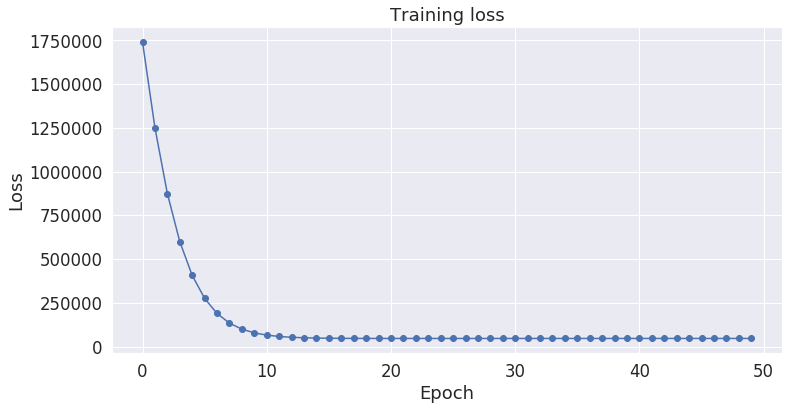

In [0]:
#Setting hyperparameters

net = GMU(out_dim = 512).cuda()
label_names = Label_names
num_labels = 23
batch_size = 512
learning_rate = 0.01
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = pd.DataFrame(0, index=['Recall','Precision','F_Score'], columns=['micro', 'macro', 'weighted', 'samples']).astype(float)
epoch_loss_set = []
epoch_aux_loss_set = []
train_dataloader =  SetTrainDataloader_MM(Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor)

# clear param store
pyro.clear_param_store()


# trainable parameters
def count_parameters_trainable(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
train_param_cnt = count_parameters_trainable(net)
print('trainable parameter count', train_param_cnt)

# Pyro param dictionary
param_dict = pyro.get_param_store().items()
print('para_dict', param_dict)

for i in param_dict:
    print ("items", i, param_dict[i])


# custom ELBO loss
def simple_mc_elbo(model, guide, *args):
    guide_trace = poutine.trace(guide).get_trace(*args)
    model_trace = poutine.trace(poutine.replay(model, trace=guide_trace)).get_trace(*args)
    elbo = model_trace.log_prob_sum() - guide_trace.log_prob_sum()
    return -elbo

# pyro svi, initialise losses
inference = SVI(model, guide, ClippedAdam({"lr": learning_rate}), loss=simple_mc_elbo)


# pyro auxiliary loss
loss_aux = SVI(model_classify, guide_classify, ClippedAdam({"lr": learning_rate}), loss=Trace_ELBO())


Train()